# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


filepath=r'dataset/df_ecom_2_2_mv_input.csv'


file_tag = "df_ecom_outlier_input"

# DSLabs functions

In [2]:
%run "dslabs_functions.py"


dslabs_functions lodaded


# Data functions

In [16]:
%run "data_functions.py"


data_functions loaded


# Load

In [22]:
# test_data=True
test_data=False

evaluate=True
# evaluate=False

if test_data==True:

    df=pd.read_csv(filepath)

    # 1% sample
    df=df.sample(frac=0.01, replace=False)
    

else:
    df=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

 
target='is_purchase'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
df.sort_values(by='day', inplace=True)



df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258334 entries, 0 to 258333
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   category_code_lvl_1  258334 non-null  float64
 1   category_code_lvl_2  258334 non-null  float64
 2   price                258334 non-null  float64
 3   is_purchase          258334 non-null  int64  
 4   activity_in_session  258334 non-null  float64
 5   week_of_month        258334 non-null  int64  
 6   is_weekend           258334 non-null  int64  
 7   day                  258334 non-null  int64  
 8   brand_value          258334 non-null  float64
 9   product_category     258334 non-null  int64  
 10  time_of_day_sin      258334 non-null  float64
 11  time_of_day_cos      258334 non-null  float64
 12  day_of_week_sin      258334 non-null  float64
 13  day_of_week_cos      258334 non-null  float64
 14  hour_sin             258334 non-null  float64
 15  hour_cos             2

In [5]:
df.head()

,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,is_view,is_cart,is_purchase,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,6.0,42.0,102.0,128.45,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.817,-0.577,-0.000,1.000
2836,0.0,6.0,10.0,770.93,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,0.899,-0.437
2837,0.0,0.0,2.0,316.53,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.398,-0.917,0.991,-0.133
2838,11.0,57.0,125.0,127.29,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,1.000,-0.027
2839,5.0,38.0,90.0,743.91,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.998,-0.068,-0.638,-0.770


# Outlier Analysis

- These are the only numeric columns that has outliers that need to be treated:
    - price
    - hour_cos


In [23]:
from dslabs_functions import get_variable_types

variable_types: dict[str, list] = get_variable_types(df)
print(variable_types)

{'numeric': ['category_code_lvl_1', 'category_code_lvl_2', 'price', 'activity_in_session', 'week_of_month', 'day', 'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos'], 'binary': ['is_purchase', 'is_weekend'], 'date': [], 'symbolic': []}


# Summary5 and var selection

#### Checking outliers

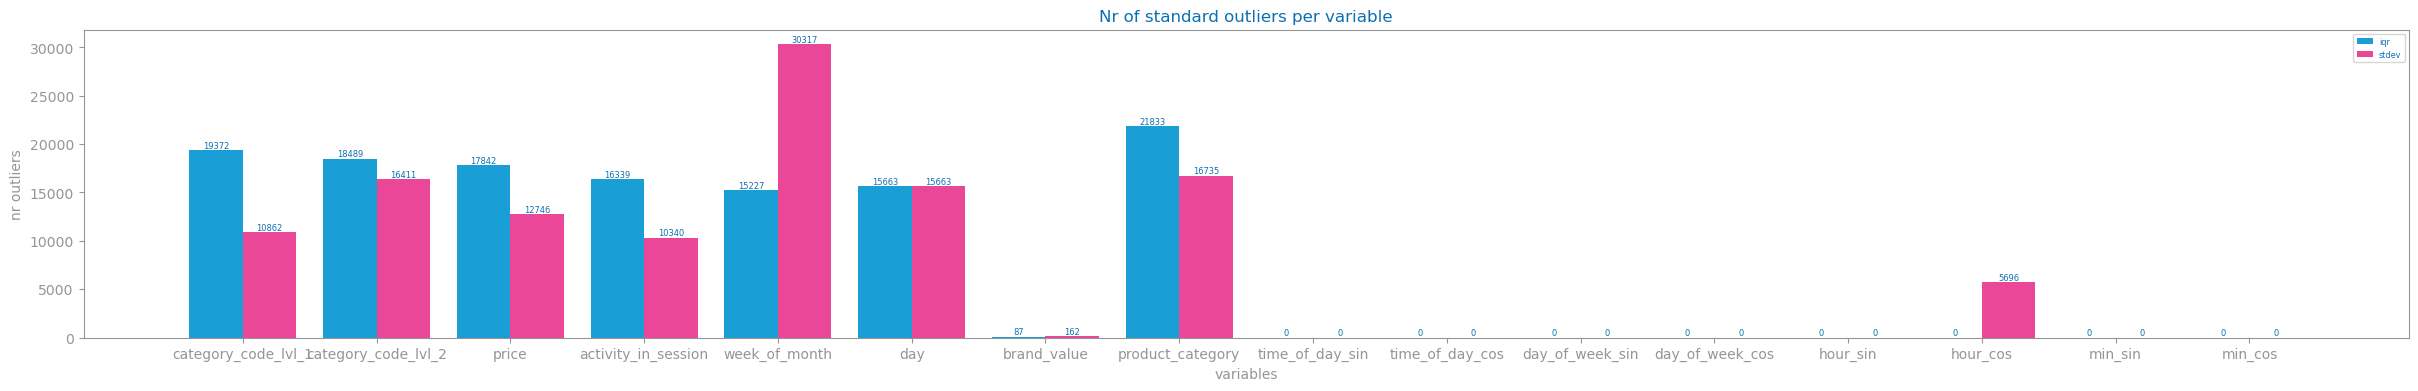

In [24]:
from pandas import Series
from matplotlib.pyplot import figure, savefig, show
from dslabs_functions import plot_multibar_chart

#This is the number of times * Standartdeviation.  
#Outliers are defined as values that are a certain distance from the mean, determined by the number of standard deviations you specified
#the higher the nr_stdev_ less outliers ww will have
NR_STDEV: int = 2


IQR_FACTOR: float = 1.5


def determine_outlier_thresholds_for_var(
    summary5: Series, std_based: bool = True, threshold: float = NR_STDEV
) -> tuple[float, float]:
    top: float = 0
    bottom: float = 0
    if std_based:
        std: float = threshold * summary5["std"]
        top = summary5["mean"] + std
        bottom = summary5["mean"] - std
    else:
        iqr: float = threshold * (summary5["75%"] - summary5["25%"])
        top = summary5["75%"] + iqr
        bottom = summary5["25%"] - iqr

    return top, bottom



def count_outliers(
    data: DataFrame,
    numeric: list[str],
    nrstdev: int = NR_STDEV,
    iqrfactor: float = IQR_FACTOR,
) -> dict:
    outliers_iqr: list = []
    outliers_stdev: list = []
    summary5: DataFrame = df[numeric].describe()

    for var in numeric:
        top: float
        bottom: float
        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=True, threshold=nrstdev
        )
        outliers_stdev += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

        top, bottom = determine_outlier_thresholds_for_var(
            summary5[var], std_based=False, threshold=iqrfactor
        )
        outliers_iqr += [
            data[data[var] > top].count()[var] + data[data[var] < bottom].count()[var]
        ]

    return {"iqr": outliers_iqr, "stdev": outliers_stdev}

# Usar a função get_variable_types() para obter as variáveis numéricas
variable_types: dict[str, list] = get_variable_types(df)
numeric: list[str] = variable_types["numeric"]


if [] != numeric:
    outliers: dict[str, int] = count_outliers(df, numeric)
    figure(figsize=(30, HEIGHT))
    plot_multibar_chart(
        numeric,
        outliers,
        title="Nr of standard outliers per variable",
        xlabel="variables",
        ylabel="nr outliers",
        percentage=False,
    )
    #savefig(f"images/{file_tag}_outliers_standard.png")
    show()
else:
    print("There are no numeric variables.")

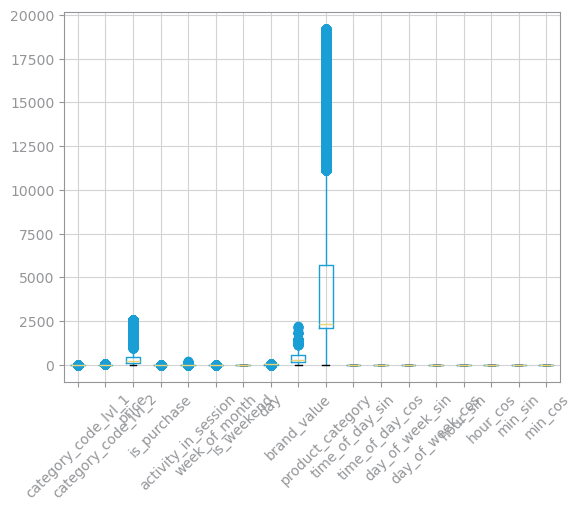

In [25]:
from matplotlib.pyplot import savefig, show


df.boxplot(rot=45)
# savefig(f"{file_tag}_global_boxplot.png")
show()


# Summary5 and var selection

In [13]:

# Analisar a variável 'price'
var_price = 'price'
summary_price: DataFrame = df[[var_price]].describe(include="all")
print("Summary for 'price':")
print(summary_price)

# Analisar a variável 'hour'
var_hour = 'hour_cos'
summary_hour: DataFrame = df[[var_hour]].describe(include="all")
print("Summary for 'hour':")
print(summary_hour)


Summary for 'price':
               price
count  258334.000000
mean      363.217366
std       364.942992
min         0.870000
25%       127.150000
50%       226.250000
75%       468.480000
max      2574.070000
Summary for 'hour':
            hour_cos
count  258334.000000
mean       -0.303065
std         0.591443
min        -1.000000
25%        -0.866000
50%        -0.500000
75%         0.259000
max         1.000000


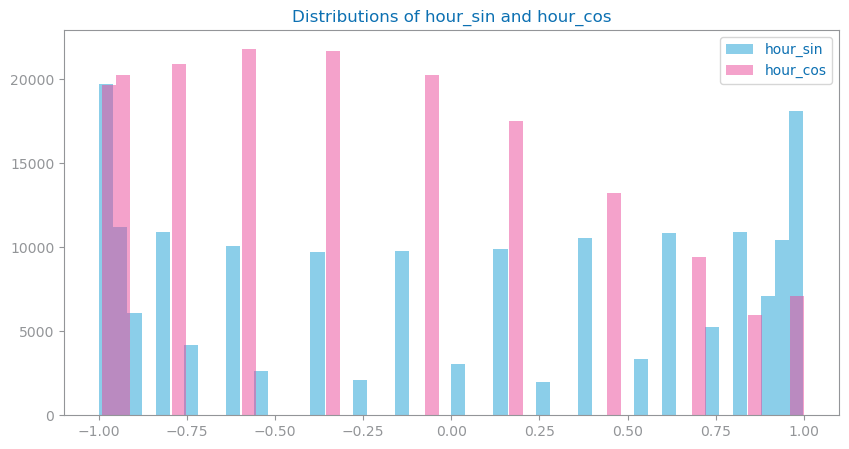

In [26]:
## Out 1 strategy aplication

# Out 1  - Truncating outliers



## Out 1 strategy aplication

In [27]:
def apply_strategy_1(df):

    df_copy=df.copy()
    
    # this script is available in data_functions originally from DSLabs site in Outlier chapter   
    df_copy=truncate_outliers(df_copy, summary5, var)
 
    return df_copy

df_1=apply_strategy_1(df)



df_1[[var]].describe()

Data after truncating outliers: (258334, 18)


,hour_cos
count,258334.000000
mean,-0.305164
std,0.587052
min,-1.000000
25%,-0.866000
50%,-0.500000
75%,0.259000
max,0.879820


In [28]:
from pandas import DataFrame
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

def apply_strategy_1(df: DataFrame, summary5: DataFrame) -> DataFrame:
    df_copy = df.copy()

    # Obter variáveis numéricas
    numeric_vars = get_variable_types(df_copy)["numeric"]
    
    if numeric_vars:
        print("Data before truncating outliers:", df.shape)
        
        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Truncar outliers
            df_copy[var] = df_copy[var].apply(
                lambda x: top if x > top else bottom if x < bottom else x
            )
        
        print("Data after truncating outliers:", df_copy.shape)
    else:
        print("There are no numeric variables")
    
    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico antes de chamar a função
df_1 = apply_strategy_1(df, summary5)



Data before truncating outliers: (258334, 18)
Data after truncating outliers: (258334, 18)


In [48]:
df_1.head()

,category_code_lvl_1,category_code_lvl_2,category_code_lvl_3,price,week_of_month,is_weekend,day,is_view,is_cart,is_purchase,time_of_day_sin,time_of_day_cos,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos,min_sin,min_cos
0,6.0,42.0,102.0,128.45,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.817,-0.577,-0.000,1.000
2836,0.0,6.0,10.0,770.93,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,0.899,-0.437
2837,0.0,0.0,2.0,316.53,0,0,0,1,0,0,0.0,1.0,1.0,0.0,0.398,-0.917,0.991,-0.133
2838,11.0,57.0,125.0,127.29,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.631,-0.776,1.000,-0.027
2839,5.0,38.0,90.0,743.91,0,0,0,1,0,0,0.0,-1.0,1.0,0.0,-0.998,-0.068,-0.638,-0.770


In [29]:

# Verificar quais colunas foram alteradas e coletar informações
altered_info = {}
for var in get_variable_types(df)["numeric"]:
    altered_indices = df.index[df[var] != df_1[var]].tolist()
    if altered_indices:
        altered_count = len(altered_indices)
        new_values = df_1.loc[altered_indices, var].to_list()
        altered_info[var] = {'altered_count': altered_count, 'new_values': new_values}

# Imprimir informações das colunas alteradas
for var, info in altered_info.items():
    print(f"Coluna '{var}' foi alterada. Número de linhas alteradas: {info['altered_count']}. Novos valores: {info['new_values']}")

Coluna 'category_code_lvl_1' foi alterada. Número de linhas alteradas: 10862. Novos valores: [5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.049761871396908, 5.04976187139

## Out 1 train/test split 

Labels=[0, 1]


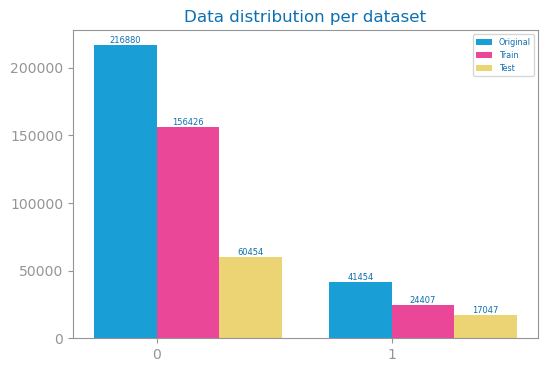

In [30]:
from pandas import concat
from sklearn.model_selection import train_test_split
from numpy import array, ndarray
from matplotlib.pyplot import figure, show
from dslabs_functions import plot_multibar_chart



# Call the function to split the data

y_1, X_1, labels, values = define_target_and_prepare_data(df_1, target)

train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=df_1.columns), y_1, data_columns=df_1.columns, target_column=target)


# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()  

## Out 1 evaluate

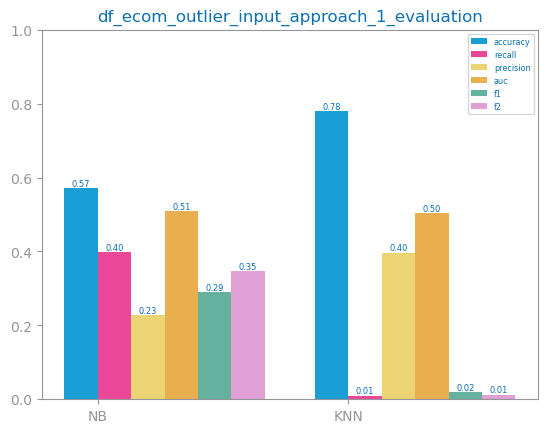

In [31]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values
if evaluate==True:

    figure()
    eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_purchase', metric="precision")
    plot_multibar_chart(
        ["NB", "KNN"], eval_1, title=f"{file_tag}_approach_1_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_1_evaluation.png")
    show()

# Out 2 - drop outlier strategy


## Out 2 strategy aplication

In [32]:
from pandas import DataFrame, Series
from dslabs_functions import (
    NR_STDEV,
    get_variable_types,
    determine_outlier_thresholds_for_var,
)

def apply_strategy_2(df: DataFrame, summary5: DataFrame) -> DataFrame:
    df_copy = df.copy()

    # Obter variáveis numéricas
    numeric_vars = get_variable_types(df_copy)["numeric"]
    
    if numeric_vars:
        print("Data before dropping outliers:", df_copy.shape)


        for var in numeric_vars:
            # Calcular os limites de outlier para a variável usando summary5
            top, bottom = determine_outlier_thresholds_for_var(summary5[var])
            
            # Identificar os outliers
            outliers: Series = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]
            # Armazenar informações sobre valores removidos

            # Remover outliers
            df_copy.drop(outliers.index, axis=0, inplace=True)
        
        print("Data after dropping outliers:", df_copy.shape)
    else:
        print("There are no numeric variables")
    
    return df_copy

# Usar a função
summary5 = df.describe()  # Calcular o resumo estatístico antes de chamar a função
df_2 = apply_strategy_2(df, summary5)

# Salvar o DataFrame resultante em um CSV, se necessário
# data_2.to_csv(f"data/{file_tag}_drop_outliers.csv", index=True)


Data before dropping outliers: (258334, 18)
Data after dropping outliers: (188630, 18)


## Out 2 train/test split 

Labels=[0, 1]


<Axes: title={'center': 'Data distribution per dataset'}>

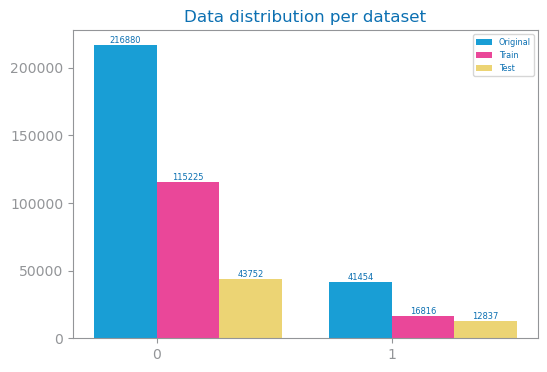

In [33]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data

y_2, X_2, labels, class_counts = define_target_and_prepare_data(df_2, target=target)


train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=df_2.columns), y_2, data_columns=df_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Out 2 evaluate

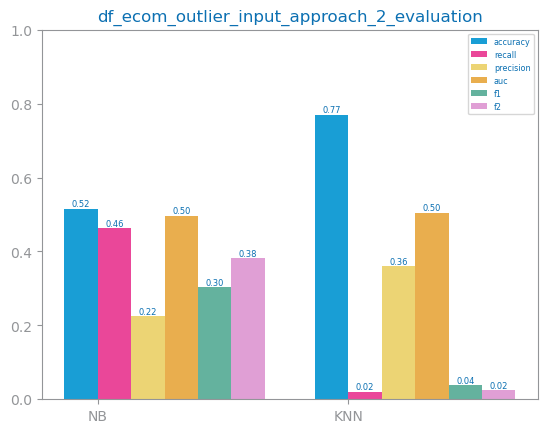

In [34]:
if evaluate ==True:

    figure()
    eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_purchase', metric="precision")
    plot_multibar_chart(
        ["NB", "KNN"], eval_2, title=f"{file_tag}_approach_2_evaluation", percentage=True
    )
    savefig(f"images/{file_tag}_approach_2_evaluation.png")
    show()

# Approach uplift comparison

## uplift df

In [37]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1



# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])



# Display the DataFrame
comparison_df

Approach 1                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.571309  0.398252  0.228163  0.509180  0.290116  0.346579   
KNN           0.778906  0.009914  0.396714  0.502831  0.019344  0.012315   

            Approach 2                                                    \
              accuracy    recall precision       auc        f1        f2   
Naive Bayes   0.515330  0.463738  0.224675  0.497102  0.302697  0.382367   
KNN           0.769584  0.020254  0.360111  0.504847  0.038351  0.024966   

               Uplift                                                    
             accuracy    recall precision       auc        f1        f2  
Naive Bayes -0.055979  0.065486 -0.003488 -0.012077  0.012582  0.035788  
KNN         -0.009322  0.010340 -0.036603  0.002016  0.019007  0.012651

# Analysis

Outlier treatment:
- Despite not having significant difference, In Outlier treatment, for now let's move with approach 1 because it has better results combined on precision and recall
     -   Why?
      - it has better accuracy, better recall and better precision

Comparing with previous dataset:
- Considering approach 1 is the best between both strategies, if we compare between previous dataset and outlier treatment, we have:
     - less precision in Knn
          - nb: the same
          - knn: 0,43 to 0,40
     - higher recall in NB:
          - nb: 0,36 to 0,40
          - knn: the same


Decision:
- For now, Let's move one with the approach from missing values
- Datset choosen:
    - Df from missing values


### Comentario:
Estás a pensar corretamente ao focar-te em reduzir falsos positivos, especialmente no contexto do teu modelo de previsão de compras. A precision é a métrica mais relevante neste cenário, pois está diretamente relacionada à proporção de previsões corretas de "compra" (is_purchase = 1) em relação ao total de previsões positivas feitas pelo modelo. No entanto, vale a pena analisar outras métricas também para ter uma visão mais completa do desempenho do modelo.

O que cada métrica significa:
Precision:

Definição: Medida de quantos dos exemplos previstos como positivos (compra) são realmente positivos.
Interpretação no teu caso: Alta precision significa que quando o modelo prevê que um produto será comprado, essa previsão está correta na maioria das vezes. Se a precision for baixa, isso significa que estás a ter muitos falsos positivos — ou seja, o modelo está a prever compras que não acontecem.
Importância: Como mencionaste, falsos positivos podem ser caros, especialmente se investires em publicidade ou marketing para produtos que o modelo erroneamente previu que seriam comprados. Por isso, aumentar a precision faz sentido no teu contexto.
Recall:

Definição: Medida de quantos dos exemplos verdadeiros positivos (compras reais) foram identificados corretamente pelo modelo.
Interpretação no teu caso: Alta recall significa que o modelo consegue identificar a maioria das compras reais. No entanto, focar-se apenas no recall pode significar que o modelo está a prever mais compras, o que pode aumentar os falsos positivos e diminuir a precision.
Importância: Se o objetivo fosse garantir que a maioria das compras fosse captada, mesmo à custa de ter mais falsos positivos, a recall seria a métrica principal. No teu caso, como queres evitar falsos positivos, deves priorizar a precision em relação à recall.
Accuracy:

Definição: A proporção de previsões corretas (tanto positivas quanto negativas) feitas pelo modelo.
Interpretação no teu caso: O accuracy mede quantas previsões (de compra ou não compra) o modelo acertou no total. No entanto, em datasets desbalanceados (como no teu, onde há muito mais eventos de "não compra"), a accuracy pode ser enganosa. Um modelo que prevê sempre "não compra" pode ter alta accuracy, mas falharia completamente em identificar compras.
Importância: A accuracy não é a métrica mais adequada para o teu caso devido ao desbalanceamento do target. Deve ser vista com cautela.
AUC (Área Sob a Curva ROC):

Definição: Mede a capacidade do modelo em distinguir entre classes (compra vs não compra), considerando todas as possibilidades de thresholds de decisão.
Interpretação no teu caso: O AUC avalia a capacidade do modelo em separar corretamente as compras das não compras, independentemente do threshold de decisão. Um AUC alto significa que o modelo está a prever corretamente os "compradores" em comparação com os "não compradores".
Importância: O AUC pode ser útil para entender a discriminância geral do modelo. Mas não é suficiente por si só para entender como está a lidar com falsos positivos, que é o teu foco.
F1 Score:

Definição: A média harmónica entre precision e recall. Dá uma visão equilibrada do desempenho quando se quer tanto minimizar falsos negativos quanto falsos positivos.
Interpretação no teu caso: O F1 é útil quando precisas de um equilíbrio entre precision e recall. Se queres reduzir falsos positivos, a precision pode ser mais importante, mas não deves ignorar totalmente a recall. O F1 combina ambas, mas tende a ser menos relevante no teu caso específico onde a precision é o foco.
Importância: Pode ajudar a equilibrar precision e recall, mas se estás mais preocupado com falsos positivos, a precision é mais relevante.
F2 Score:

Definição: Similar ao F1, mas coloca mais peso na recall (proporção de verdadeiros positivos encontrados).
Interpretação no teu caso: O F2 score valoriza mais a capacidade de identificar todas as compras, mesmo à custa de ter mais falsos positivos. No teu caso, isto pode ser menos útil, já que estás mais preocupado em não ter falsos positivos.
Importância: Provavelmente menos relevante para o teu cenário, já que priorizas precision.
Conclusão: Focar na Precision
Com base no teu objetivo — evitar falsos positivos — faz todo o sentido priorizar a precision na análise de performance dos teus modelos. No entanto, também é importante acompanhar outras métricas, como o recall, para garantir que o modelo não está a ignorar demasiadas compras reais.

O que fazer agora:
Analisar precision como a métrica principal.
Ver se o trade-off com recall (medido através do F1) é aceitável. Um aumento excessivo de precision pode reduzir a recall, o que significa que podes perder algumas compras reais.
Considera a AUC como uma métrica secundária, para garantir que o modelo está a distinguir bem entre compradores e não compradores.
Se a precision for significativamente melhor na Approach 2 (delete outliers), talvez essa seja a abordagem preferida, já que estás a obter menos falsos positivos, mesmo que isso signifique descartar alguns dados.

# save to csv

In [38]:
if test_data==False:
    

    data_save=df.copy()

    # apply winning strategy
    data_save=apply_strategy_1(data_save,summary5)
        
    data_save.to_csv(f"dataset/df_ecom_2_3_outliers_input.csv", index=False)
    
    print(data_save.columns)

Data before truncating outliers: (258334, 18)
Data after truncating outliers: (258334, 18)
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price', 'is_purchase',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos'],
      dtype='object')


## train test csv

In [39]:
if test_data==False:
    

    data_save_copy=data_save.copy()

    
    y, X, labels, class_counts = define_target_and_prepare_data(data_save_copy, target=target)

    train, test = split_data_save_csv(pd.DataFrame(X, columns=data_save_copy.columns), y, data_columns=data_save_copy.columns, target_column=target)  
    
    train.to_csv(f"dataset/df_ecom_2_3_outliers_input_train.csv", index=False)
    print(train.columns)
    
    test.to_csv(f"dataset/df_ecom_2_3_outliers_input_test.csv", index=False)
    print(test.columns)

Labels=[0, 1]
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
Index(['category_code_lvl_1', 'category_code_lvl_2', 'price',
       'activity_in_session', 'week_of_month', 'is_weekend', 'day',
       'brand_value', 'product_category', 'time_of_day_sin', 'time_of_day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'hour_sin', 'hour_cos', 'min_sin',
       'min_cos', 'is_purchase'],
      dtype='object')
